In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from collections import defaultdict
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
!pip install contractions
import contractions
import re
import string

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 708.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 2.5 MB/s eta 0:00:00
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

# Metadata

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# keyword 0.8%, location 33%
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
# keyword 0.8%, location 33%
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

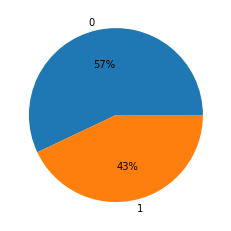

In [9]:
# balanced data
x = train.target.value_counts()
labels = np.array(x.index)
sizes = np.array((x/x.sum())*100)
plt.pie(sizes, labels = labels, autopct='%.0f%%')
plt.show()

In [10]:
# duplicates with different labels
duplicates = train.groupby('text').filter(lambda x: x['target'].nunique()>1 ).sort_values('text')
duplicates

,id,keyword,location,text,target
4290,6094,hellfire,"Jubail IC, Saudi Arabia.",#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,1
4244,6031,hazardous,"New Delhi, Delhi",#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,0
4221,5996,hazardous,NaN,#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,1
4239,6023,hazardous,"Mysore, Karnataka",#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,1
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,0
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1


**Keyword**

In [11]:
print('keyword column has', train['keyword'].nunique(), 'unique values as below')
print(train['keyword'].unique())

keyword column has 221 unique values as below
[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated

<AxesSubplot:ylabel='keyword'>

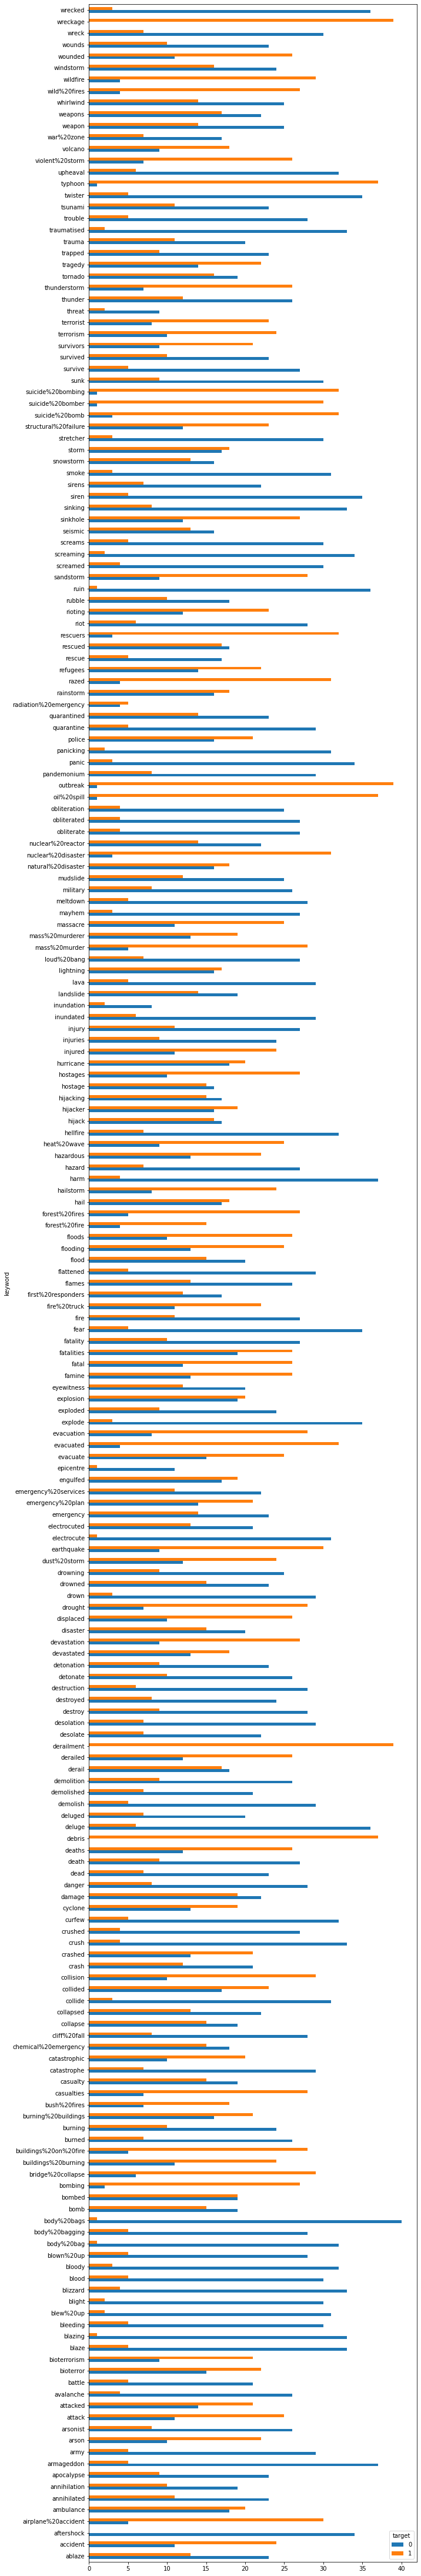

In [12]:
keyword = train.copy()
keyword = keyword.groupby('keyword').target.value_counts()
keyword = keyword.to_dict()

word = []
target = []
count = []
for key, value in keyword.items():
    word.append(key[0])
    target.append(key[1])
    count.append(value)

keyword = pd.DataFrame({'keyword': word, 'target': target, 'count': count})
keyword = keyword.reset_index()
keyword_pivot = keyword.pivot(index='keyword',columns='target',values='count')
keyword_pivot.plot.barh(rot=0, figsize=(10, 80))
# 1 - wreckage, derailment, debris
# 0 - aftershock

**Location**

In [13]:
print('location column has', train['location'].nunique(), 'unique values')
print(train['location'].unique())
# too many null values, too dirty

location column has 3341 unique values
[nan 'Birmingham' 'Est. September 2012 - Bristol' ... 'Vancouver, Canada'
 'London ' 'Lincoln']


# Pre-processing

In [14]:
nltk.download('stopwords')
sw = stopwords.words('english')

def process(text):
    # lowercase
    text = text.lower()
    # expand contractions
    text = contractions.fix(text)
    # remove urls
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    # remove HTML tags
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    text = re.sub(html, ' ', text)
    # remove irrelevant characters - punctuations and numbers
    #text = re.sub(r'[^a-zA-Z]', ' ', text)
    # remove punctuations
    #table = str.maketrans('','',string.punctuation)
    #text = text.translate(table)
    text = re.sub('['+string.punctuation+']', ' ', text)
    # remove numbers
    text = re.sub(r'\d+', ' ', text)
    # remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]',r' ', text)
    # remove newline \n
    text = re.sub('\n', ' ', text)
    # remove special characters
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # remove extra whitespaces
    pattern = r'^\s*|\s\s*'
    text = re.sub(pattern, ' ', text).strip()
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in sw])
    
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
train['text'] = train['text'].apply(lambda x: process(x))

In [16]:
train[301:311]

,id,keyword,location,text,target
301,443,apocalypse,NaN,short reading apocalypse spirit angel took top enormous high mountain,1
302,444,apocalypse,Tokyo,enjoyed live action attack titan every time see posters reminded freshly clean coiffed everyone apocalypse,0
303,445,apocalypse,NaN,liked youtube video minecraft night lucky block mod bob apocalypse wither mod showcase,0
304,446,armageddon,"California, United States",pbban temporary avysss armageddon kill flags fast xp reason,0
305,447,armageddon,"California, United States",pbban temporary russaky armageddon kill flags fast xp reason,0
306,448,armageddon,#FLIGHTCITY UK,official vid doublecups trubgme prod thisizbwright armageddon,0
307,450,armageddon,NaN,ouvindo peace love armageddon,0
308,451,armageddon,NaN,best movie ever seen armageddon,0
309,452,armageddon,"Alphen aan den Rijn, Holland",bed time wake unless revolution armageddon start,0
310,453,armageddon,NaN,red faction armageddon microsoft xbox full read ebay,0


# Text

**Statistics**

<AxesSubplot:>

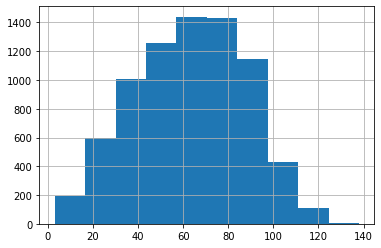

In [17]:
train['text'].str.len().hist() # number of characters

<AxesSubplot:>

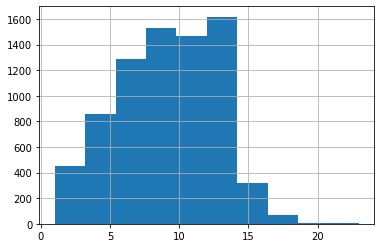

In [18]:
train['text'].str.split().map(lambda x: len(x)).hist() # number of words

<AxesSubplot:>

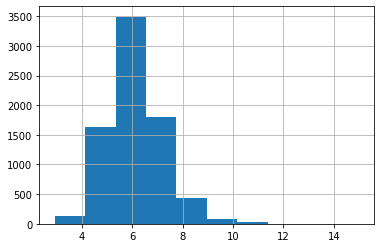

In [19]:
train['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist() # average word length

**N-grams**

In [20]:
train_0 = train.copy()
train_0 = train_0[train_0.target == 0]
train_1 = train.copy()
train_1 = train_1[train_1.target == 1]

In [21]:
def generate_count(dataframe):
    corpus = []
    x, y = [], []
    new = dataframe['text'].str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    counter = Counter(corpus)
    most = counter.most_common()
    for word,count in most[:40]:
        x.append(word)
        y.append(count)
    return x, y

In [22]:
x_0, y_0 = generate_count(train_0)
x_1, y_1 = generate_count(train_1)

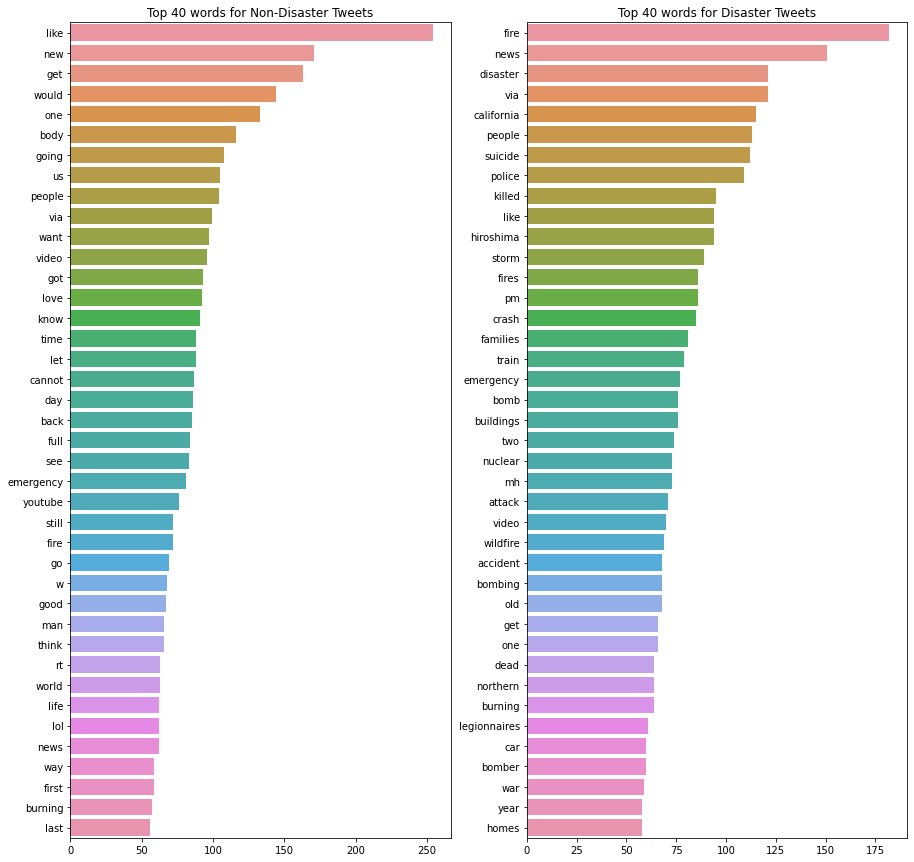

In [23]:
n = 2
fig, ax = plt.subplots(1, n, figsize=(15, 15))
sns.barplot(x=y_0, y=x_0, ax=ax[0]).set_title('Top 40 words for Non-Disaster Tweets')
sns.barplot(x=y_1, y=x_1, ax=ax[1]).set_title('Top 40 words for Disaster Tweets')
fig.show()
# 0 - mostly verbs
# 1 - most already give info about disaster

In [24]:
def generate_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:40]

In [25]:
bigram_0 = generate_ngram(train_0['text'],n=2)
x_0, y_0 = map(list,zip(*bigram_0))
bigram_1 = generate_ngram(train_1['text'],n=2)
x_1, y_1 = map(list,zip(*bigram_1))

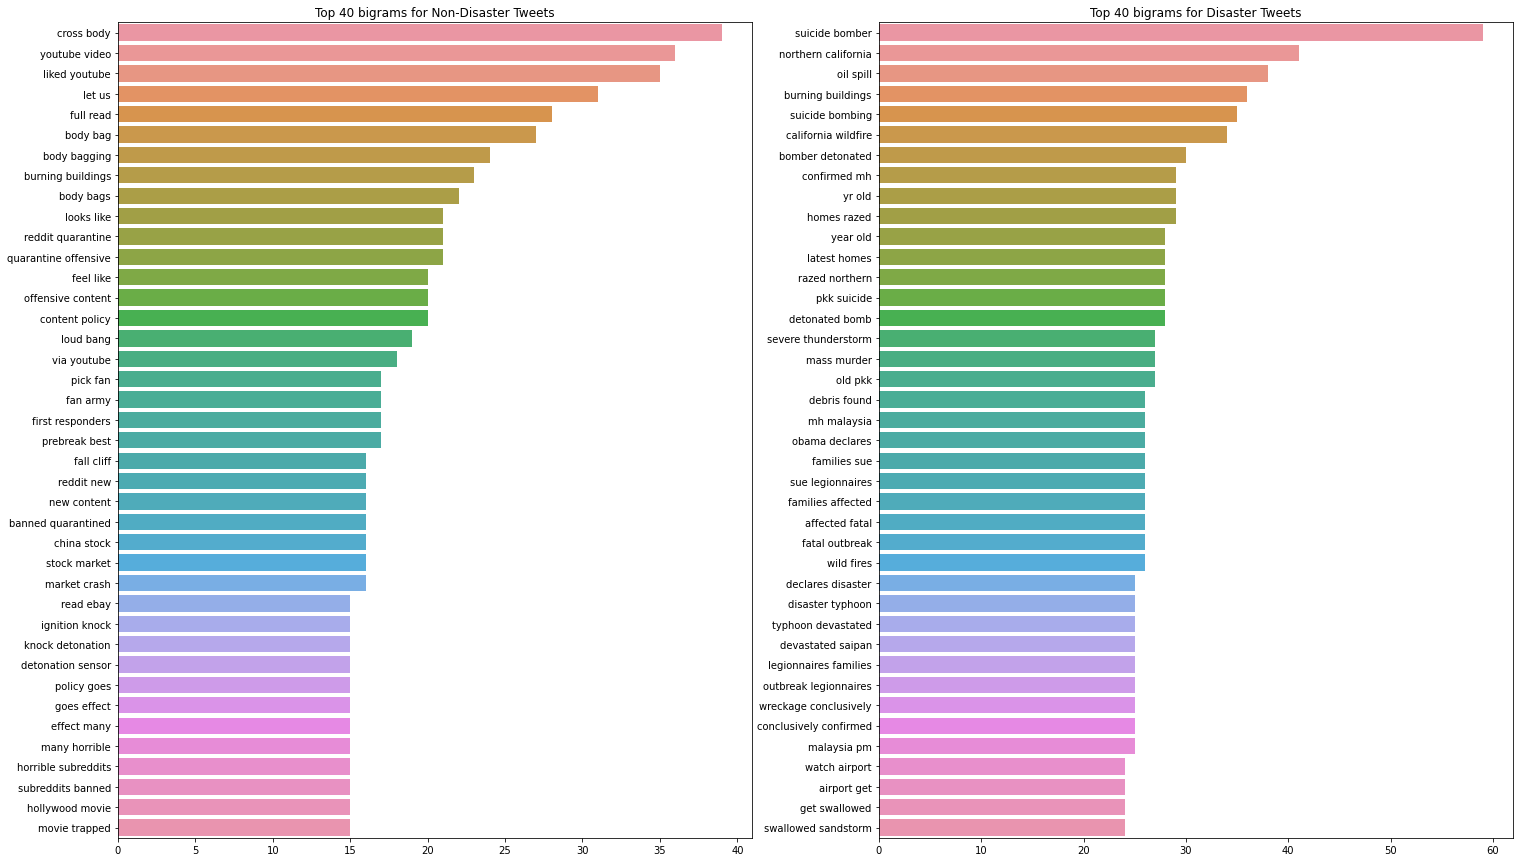

In [26]:
n = 2
fig, ax = plt.subplots(1, n, figsize=(25, 15))
sns.barplot(x=y_0, y=x_0, ax=ax[0]).set_title('Top 40 bigrams for Non-Disaster Tweets')
sns.barplot(x=y_1, y=x_1, ax=ax[1]).set_title('Top 40 bigrams for Disaster Tweets')
fig.show()
# 0 - mostly about reddit, youtube
# 1 - most give more information than unigram